In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertForSequenceClassification,BertConfig
import tensorflow as tf

2024-06-04 11:54:16.750407: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 11:54:16.750507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 11:54:16.871594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_dataset = pd.read_csv('/kaggle/input/emotion-classification/train_preprocess_indoNLU.csv')
valid_dataset = pd.read_csv('/kaggle/input/emotion-classification/valid_preprocess_indoNLU.csv')

In [6]:
# Merge dataset
df = df = pd.concat([train_dataset, valid_dataset], axis=0, ignore_index=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3961 entries, 0 to 3960
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3961 non-null   object
 1   tweet   3961 non-null   object
dtypes: object(2)
memory usage: 62.0+ KB


In [8]:
#Shuffle Dataset
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,label,tweet
0,love,Karena Cinta Yang Sesungguhnya Berasal dari Ha...
1,anger,Mrk mo ceritain apapun ttglo... toh mrk sbnrny...
2,happy,Jalan-jalan cari suasana baru dan pengetahuan ...
3,love,Pada saat dirimu masih seorang anak perempuan ...
4,happy,Ini yang kami sebut KEBAHAGIAAN Member SJ mung...


In [10]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['tweet'], df['label'], test_size=0.3, random_state=42)

# Ensure texts are converted to lists and are all strings
train_texts = train_texts.astype(str).tolist()
val_texts = val_texts.astype(str).tolist()

# Debug: Print the first few elements to ensure they're strings
print("Sample train texts:", train_texts[:5])
print("Sample val texts:", val_texts[:5])

# Tokenize data
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

def tokenize_function(texts):
    # Debug: Print the input to the tokenizer
    print("Input to tokenizer:", texts[:5])
    return tokenizer(texts, padding=True, truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# Debug: Print the tokenized encodings to ensure they are correct
print("Sample train encodings:", {key: val[:5] for key, val in train_encodings.items()})

# Convert to TensorFlow dataset
def convert_to_tf_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

train_dataset = convert_to_tf_dataset(train_encodings, train_labels.tolist())
val_dataset = convert_to_tf_dataset(val_encodings, val_labels.tolist())

train_dataset = train_dataset.shuffle(len(train_texts)).batch(8)
val_dataset = val_dataset.batch(16)


Sample train texts: ['Eh [USERNAME] sama [USERNAME] kalian lahiran? Congrats yak, nih gue kasih hadiah kecil kecilan(?) moga suka, sering sering maen sama samcho ganteng ya ntar biar jadi anak hitz lol [URL]', 'Mungkin move on juga ingin mengajarkan kita untuk LEBIH TULUS memaafkan, dan merelakan dia yg pergi. Atau mungkin, move on juga ingin menyadarkan kita bahwa cinta yg sesunguhnya bukanlah CINTA YANG PENUH EKSPEKTASI, melainkan CINTA TANPA EKSPEKTASI.', 'dalam hati aku menanti kuserahkan hati sebagai tanda ketulusan cinta', 'hanya kamu yang bisa membuat aku jadi tergila membuat aku jatuh cinta karena tak ada yang lain sepertimu', 'Kebanyakan cewek kriteria nyari pacar pengen yg lucu, padahal kalo menurut cewek, ganteng= lucu. Jadi definisi lucu disini adalah ganteng. Kalian yg jele dan qismin tolong pahami ini...']
Sample val texts: ['Belajar bilang Alhamdulillah kalo dikasih masa masa yang sulit. Alhamdulillah Allah masih sayang, makanya diuji. Alhamdulillah diingetinnya di dunia

In [12]:
# Load model
num_of_emotions = len(label_encoder.classes_)
config =BertConfig.from_pretrained('indobenchmark/indobert-base-p2', hidden_dropout_prob=0.3, num_labels=num_of_emotions)
model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2',config=config)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train model
history = model.fit(train_dataset, epochs=2, validation_data=val_dataset)

# Evaluate model
eval_result = model.evaluate(val_dataset)
print(eval_result)

Epoch 1/2


I0000 00:00:1717502337.204541     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


347/347 [==============================] - 148s 226ms/step - loss: 1.0494 - accuracy: 0.5920 - val_loss: 0.9734 - val_accuracy: 0.6484
Epoch 2/2
75/75 [==============================] - 5s 70ms/step - loss: 0.9135 - accuracy: 0.6930
[0.9135287404060364, 0.6930193305015564]


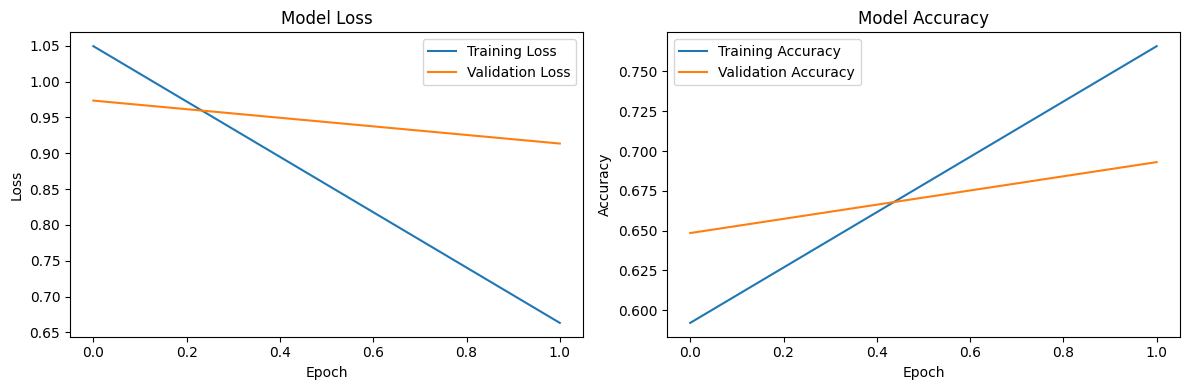

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
model.save_pretrained('/kaggle/working/emotion_classification_model')
tokenizer.save_pretrained('/kaggle/working/emotion_classification_tokenizer')


('/kaggle/working/emotion_classification_tokenizer/tokenizer_config.json',
 '/kaggle/working/emotion_classification_tokenizer/special_tokens_map.json',
 '/kaggle/working/emotion_classification_tokenizer/vocab.txt',
 '/kaggle/working/emotion_classification_tokenizer/added_tokens.json')

In [21]:
# Prepare the test data
test_texts = ['Sekolah hari ini rasanya seperti kuburan karena dia tidak masuk kelas ']

# Tokenize the test data
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="tf")

test_encodings = tokenize_function(test_texts)

# Make predictions
outputs = model(test_encodings)

# Get the predicted class
predictions = tf.argmax(outputs.logits, axis=1).numpy()

# Transform the predicted indices back to the original labels
predicted_labels = label_encoder.inverse_transform(predictions)

probabilities = tf.nn.softmax(outputs.logits, axis=1).numpy()

# Display the results
for text, label, probs in zip(test_texts, predicted_labels, probabilities):
    print(f"Text: {text}\nPredicted Emotion: {label}\n")
    print("Probabilities:")
    for emotion, prob in zip(label_encoder.classes_, probs):
        print(f"  {emotion}: {prob:.4f}")
    print("\n")

Text: Sekolah hari ini rasanya seperti kuburan karena dia tidak masuk kelas 
Predicted Emotion: 4

Probabilities:
  0: 0.0181
  1: 0.0323
  2: 0.0067
  3: 0.0073
  4: 0.9356




0: Anger
1: fear
2: Happy
3: Love
4: Sad